Make Heapmap graph of CPU usage
===

motivation
---

* The number of CPU cores are incresing these days.
* Line graph, a traditional way of visualization, doesn't scale with the number of CPU.
  (e.g Visualizing 100 CPUs, there are 100 lines!)
* As CPU resource usage tends to be bimodal(many idle CPUs and few high CPUs), statistical way, like getting average or sum, can often fail to tell us what we want to know.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

In [2]:
df = pd.read_csv('sar_CPU_ALL.log', sep='\s+', skiprows=[0]) 
# Now sar_CPU_ALL.log is artificial, need more modifications for actual data.

Rename columns.

In [3]:
df.columns=["TIME", "CPU", "user", "nice", "system", "iowait", "steal", "idle"]

Exclude rows which column "CPU" is "all".

In [5]:
df = df[df["CPU"] != "all"]

In [6]:
df['num'] = [1 for i in range(len(df))]

In [7]:
df.head()

,TIME,CPU,user,nice,system,iowait,steal,idle,num
1,00:10:01,0,21.06,0.0,0.6,0.03,0.0,98.32,1
2,00:10:01,1,21.06,0.0,0.6,0.03,0.0,98.32,1
3,00:10:01,2,21.06,0.0,0.6,0.03,0.0,98.32,1
4,00:10:01,3,21.06,0.0,0.6,0.03,0.0,98.32,1
5,00:10:01,4,21.06,0.0,0.6,0.03,0.0,98.32,1


%user heatmap of a particular moment
====

In [8]:
moment = '00:20:01'
snapshot_all_users = df[df.TIME == moment]['user']

In [9]:
snapshot_all_users

18    21.06
19     1.06
20    55.06
21    59.06
22    58.06
23    52.06
24    61.06
25    49.06
26     0.06
27     2.50
28    21.06
29    41.06
30    38.06
31    72.06
32    71.06
33    91.06
Name: user, dtype: float64

Reshape snapshot_all_users from 1-dimention to multi array

In [10]:
# If the side_len is NOT expr(n), below procedure does not work properly..
side_len = int(math.sqrt(len(snapshot_all_users)))

snapshot_all_users_list = snapshot_all_users.reshape([side_len, side_len])

In [11]:
snapshot_all_users_list

array([[  2.10600000e+01,   1.06000000e+00,   5.50600000e+01,
          5.90600000e+01],
       [  5.80600000e+01,   5.20600000e+01,   6.10600000e+01,
          4.90600000e+01],
       [  6.00000000e-02,   2.50000000e+00,   2.10600000e+01,
          4.10600000e+01],
       [  3.80600000e+01,   7.20600000e+01,   7.10600000e+01,
          9.10600000e+01]])

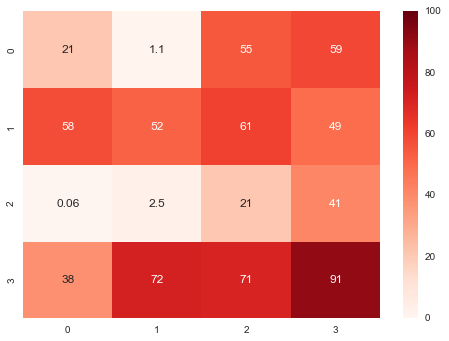

In [12]:
sns.heatmap(snapshot_all_users_list,
            cmap='Reds',
            annot=True, 
            vmin=0,
            vmax=100)

Time-series %user heatmap
====

In [13]:
df_bak = df.copy()

Round values for bottling.

Bottles are 0%, 10%, 20%, ..., 100%

In [14]:
df.user = df.user.apply(lambda x: np.round(x, -1))

In [15]:
df.head(5)

,TIME,CPU,user,nice,system,iowait,steal,idle,num
1,00:10:01,0,20.0,0.0,0.6,0.03,0.0,98.32,1
2,00:10:01,1,20.0,0.0,0.6,0.03,0.0,98.32,1
3,00:10:01,2,20.0,0.0,0.6,0.03,0.0,98.32,1
4,00:10:01,3,20.0,0.0,0.6,0.03,0.0,98.32,1
5,00:10:01,4,20.0,0.0,0.6,0.03,0.0,98.32,1


In [16]:
cpu_pivot = pd.pivot_table(data=df,values='num',
                          index='user',
                          columns='TIME',
                          aggfunc=sum)

In [17]:
cpu_pivot

TIME,00:10:01,00:20:01,00:30:01,00:40:01,00:50:02,01:00:01
user,,,,,,
0.0,NaN,3.0,NaN,NaN,NaN,NaN
20.0,8.0,2.0,NaN,NaN,2.0,NaN
30.0,3.0,NaN,NaN,8.0,NaN,9.0
40.0,5.0,2.0,7.0,6.0,NaN,4.0
50.0,NaN,2.0,3.0,1.0,NaN,NaN
60.0,NaN,4.0,6.0,NaN,NaN,NaN
70.0,NaN,2.0,NaN,2.0,NaN,NaN
90.0,NaN,1.0,NaN,NaN,NaN,NaN


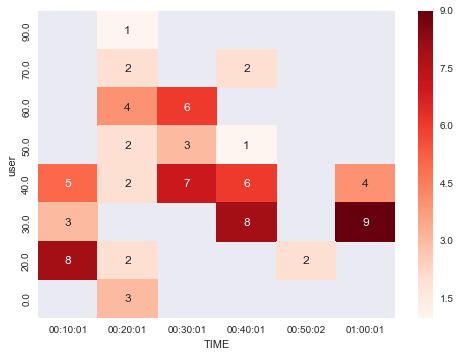

In [18]:
ax = sns.heatmap(cpu_pivot,annot=True, fmt='g', cmap='Reds')
ax.invert_yaxis()

FacetGrid
-----------

In [19]:
df = df_bak.copy()

Modify type of the 'CPU' coz we want order by number.

In [20]:
df['CPU'] = df['CPU'].astype(int)

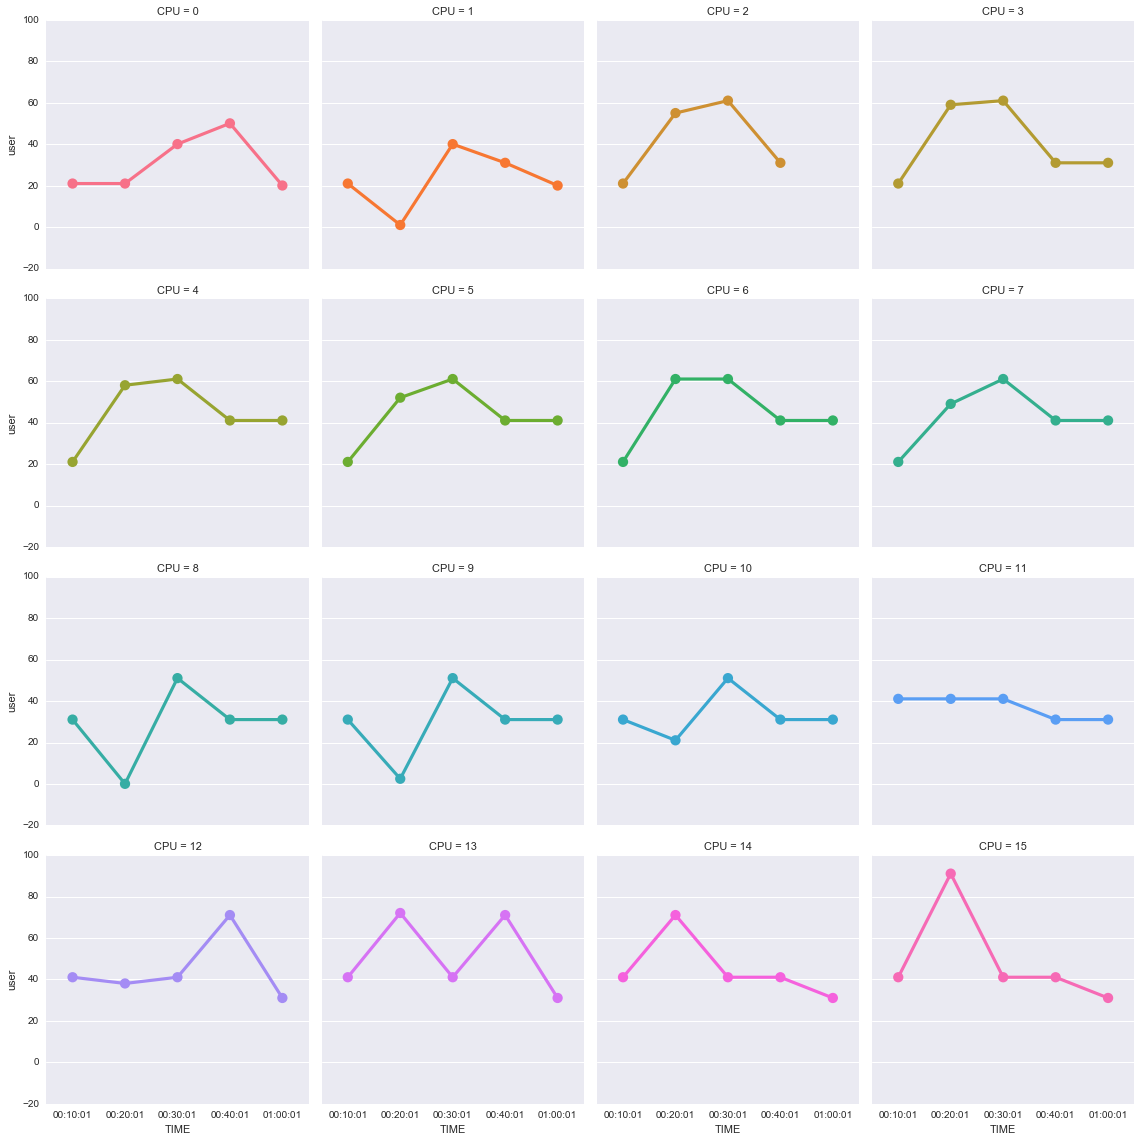

In [21]:
grid = sns.FacetGrid(df, col='CPU', hue="CPU", col_wrap=4, size=4)
grid.map(sns.pointplot, 'TIME', 'user')